# Cosine similarity

Calculate cosine similarity between:
- dataset separation direction (obtained by linear discriminant analysis)
- instrument classification direction (coefficients of binary instrument classifier)

In [1]:
%matplotlib inline

import sys 
# add parental directory to Python path
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import pandas as pd
import pickle
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
param_grid = {'LR_param': {'C':[10**k for k in range(-8, 4, 1)]}, 
              'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

# # only consider 10 mutual classes between Openmic and IRMAS dataset
# with open("../data/openmic-2018/openmic_classmap_10.json", "r") as f: 
#     openmic_class_map = json.load(f)
    
with open("../data/class_align.json", "r") as f: 
    class_align = json.load(f)

with open("../data/genre_map.json", "r") as f: 
    genre_map = json.load(f)

with open("../data/instrument_map.json", "r") as f: 
    instrument_map = json.load(f)

# select 'global' or 'classwise' bias correction
# 'global' uses only dataset identity as additional information 
# while 'classwise' also use class-labels

add_info = 'classwise'
save_dir = os.path.join('../results', add_info)

## orginal space

In [3]:
cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train set': [],
                          'cosine similarity': [],
                         })
project_method = '-lda'

for instrument in class_align:
    for embedding in ['vggish', 'openl3', 'yamnet']:
        for train_set in ['irmas', 'openmic']:

            embedding_sim = pd.DataFrame({'instrument': [],
                'embedding': [],
                'train set': [],
                'cosine similarity': [],
                })
            
            embedding_sim['instrument'] = [instrument]
            embedding_sim['embedding'] = [embedding]
            embedding_sim['train set'] = [train_set]

            # load dataset separation direction
            file = open(os.path.join(save_dir, 'LDAcoef_' + train_set + '_' + 
                                     embedding + project_method + '.pickle'), 'rb')
            dataset_sep = pickle.load(file)
            file.close()

            # load the trained instrument classifier coefficients
            file = open(os.path.join(save_dir, 'models_' + train_set + '_' +
                                      embedding + '.pickle'), 'rb')
            inst_sep = pickle.load(file)
            file.close()

            embedding_sim['cosine similarity'] = [cosine_similarity(inst_sep[instrument].best_estimator_.coef_, dataset_sep[instrument])[0][0]]
            
            cosine_sim = cosine_sim.append(embedding_sim)
    
cosine_sim.to_csv(os.path.join(save_dir, 'cosine_similarity.csv'), index=False)

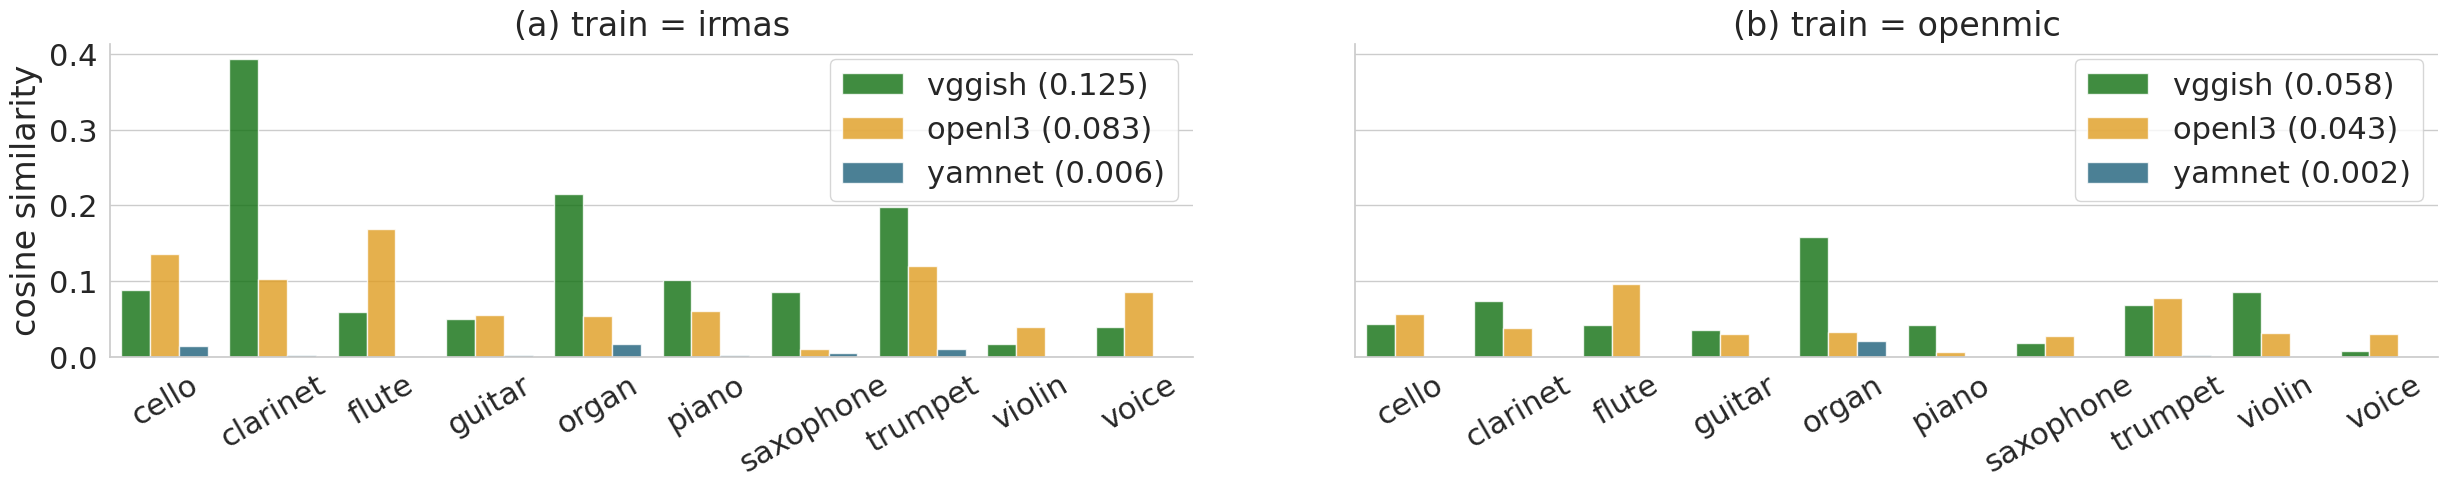

In [4]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=2)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = pd.read_csv(os.path.join(save_dir, 'cosine_similarity.csv'))
df['cosine similarity'] = abs(df['cosine similarity'])
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2.5, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
handles, labels = a0.get_legend_handles_labels()
df_irmas = df[df['train set']=='irmas']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text, ncol=1, loc=1)
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
handles, labels = a1.get_legend_handles_labels()
df_openmic = df[df['train set']=='openmic']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text, ncol=1, loc=1)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)
plt.savefig(os.path.join(save_dir, 'cosine_similarity.pdf'), bbox_inches='tight')

## kernelized space
(after explicit nonlinear transformation)

In [5]:
cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train set': [],
                          'cosine similarity': [],
                         })
project_method = 'lda'

for instrument in class_align:
    for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
        for train_set in ['irmas', 'openmic']:

            embedding_sim = pd.DataFrame({'instrument': [],
                'embedding': [],
                'train set': [],
                'cosine similarity': [],
                })
            
            embedding_sim['instrument'] = [instrument]
            embedding_sim['embedding'] = [embedding]
            embedding_sim['train set'] = [train_set]

            # load dataset separation direction
            file = open(os.path.join(save_dir, 'LDAcoef_' + train_set + '_' + 
                                     embedding + project_method + '.pickle'), 'rb')
            dataset_sep = pickle.load(file)
            file.close()

            # load the trained instrument classifier coefficients
            file = open(os.path.join(save_dir, 'models_' + train_set + '_' +
                                      embedding + '.pickle'), 'rb')
            inst_sep = pickle.load(file)
            file.close()

            embedding_sim['cosine similarity'] = [cosine_similarity(inst_sep[instrument].best_estimator_.coef_, dataset_sep[instrument])[0][0]]
            
            cosine_sim = cosine_sim.append(embedding_sim)
    
cosine_sim.to_csv(os.path.join(save_dir, 'cosine_similarity-k.csv'), index=False)

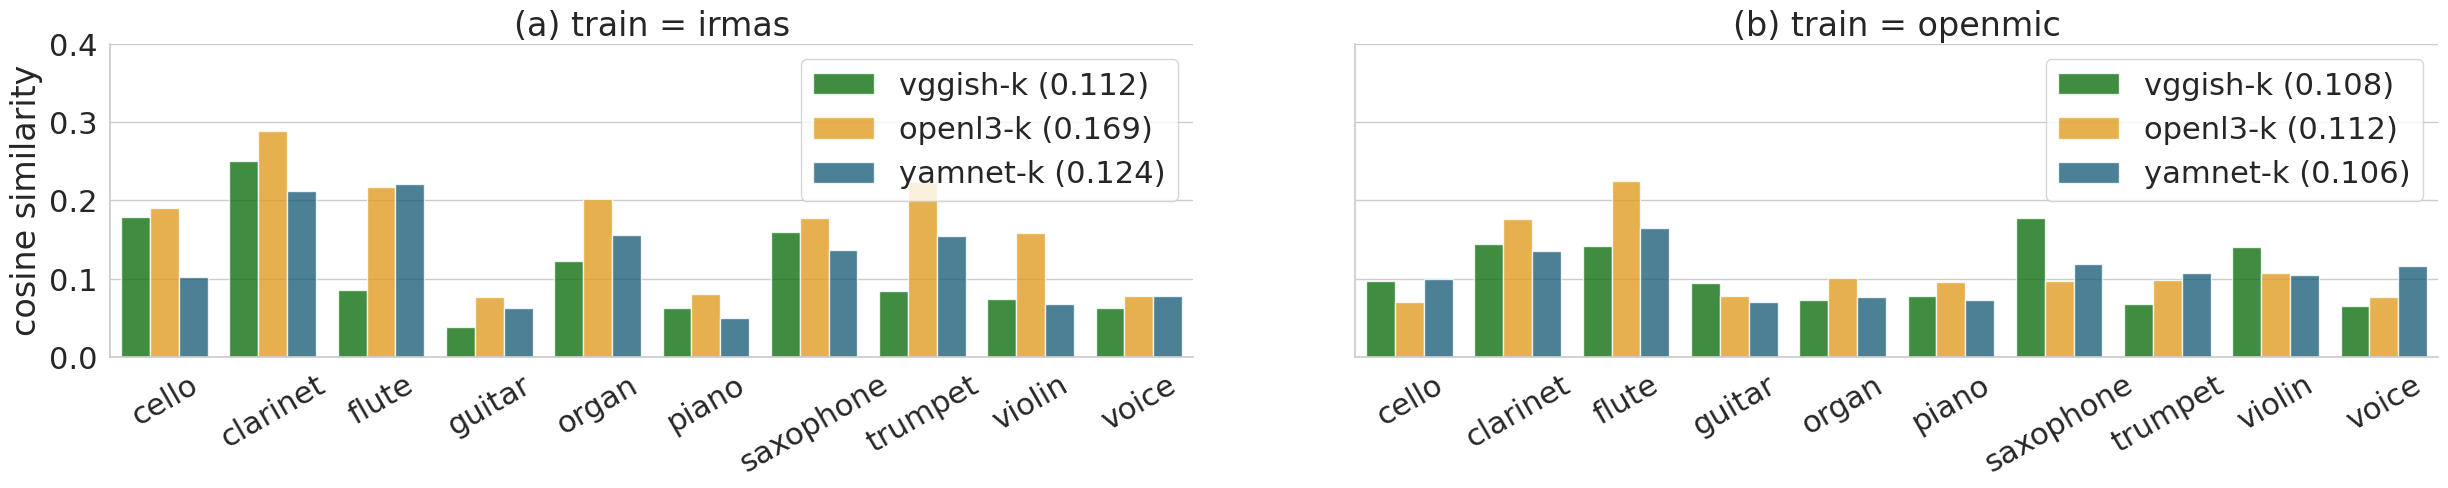

In [6]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=2)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish-k', 'openl3-k', 'yamnet-k']
    
df = pd.read_csv(os.path.join(save_dir, 'cosine_similarity-k.csv'))
df['cosine similarity'] = abs(df['cosine similarity'])
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2.5, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
handles, labels = a0.get_legend_handles_labels()
df_irmas = df[df['train set']=='irmas']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text, ncol=1, loc=1)
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
handles, labels = a1.get_legend_handles_labels()
df_openmic = df[df['train set']=='openmic']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text, ncol=1, loc=1)
a1.set_ylim([0,0.4])

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)
plt.savefig(os.path.join(save_dir, 'cosine_similarity-k.pdf'), bbox_inches='tight')